In [268]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import warnings
from pathlib import Path
from v1dd_public import ARTIFACT_DIR
from scipy import stats
from v1dd_public import utils
from allen_v1dd.client import OPhysClient
from allen_v1dd.client.ophys_session import OPhysSession
from allen_v1dd.stimulus_analysis import LocallySparseNoise
import statsmodels.stats.multicomp as multi
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from collections import defaultdict
from scipy.stats import ks_2samp
from allen_v1dd.client import OPhysClient

np.random.seed(42) # set seed for reproducibility

In [269]:
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [575]:
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2 

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


In [576]:
base_folder = "/home/naomi/Desktop/data/V1dd_nwbs"
client = OPhysClient(base_folder)
session_ids = client.get_all_session_ids()

In [ ]:
def find_subfields(cell, lsn_vals, pvals, design_matrix, response_thresh_alpha=0.05, visualize=False):
    '''
    Find the subfield of a cell that responds to the LSN stimulus.
    '''

    # pull out the LSN values and p-values for the cell
    lsn_vals_cell = lsn_vals[:, cell]
    pvals_cell = pvals[:, cell]

    # find the responsive trials and corresponding stimuli for those trials 
    is_trial_responsive = pvals_cell < response_thresh_alpha
    design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 4) & (counts_stim_for_resp_trials_on >= 20)  # threshold for significance

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -4) & (counts_stim_for_resp_trials_off >= 20)  # threshold for significance

    # check for "islands"
    on_subfield_pixels_all = np.where(on_results == True)
    on_subfield = []
    if on_results.sum() > 1:
        biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
        on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
        for x, y in zip(on_subfield_pixels_all[0], on_subfield_pixels_all[1]):
            distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
            if (distance < 0.1) or (distance > 1.5):
                continue
            elif distance < 1.5:
                on_subfield.append([x, y])
    elif on_results.sum() == 1:
        on_subfield.append([on_subfield_pixels_all[0][0], on_subfield_pixels_all[1][0]])
    on_subfield = np.array(on_subfield)
    on_results_new = np.zeros_like(on_results)
    if on_subfield.size > 0:
        on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1
    
    off_subfield_pixels_all = np.where(off_results == True)
    off_subfield = []
    if off_results.sum() > 1:
        biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
        off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
        for x, y in zip(off_subfield_pixels_all[0], off_subfield_pixels_all[1]):
            distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
            if (distance < 0.1) or (distance > 1.5):
                continue
            elif distance < 1.5:
                off_subfield.append([x, y])
    elif off_results.sum() == 1:
        off_subfield.append([off_subfield_pixels_all[0][0], off_subfield_pixels_all[1][0]])
    off_subfield = np.array(off_subfield)
    off_results_new = np.zeros_like(off_results)
    if off_subfield.size > 0:
        off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

    if visualize:
        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        axs[1, 3].axis('off')

        return on_subfield, off_subfield, fig

    return on_subfield, off_subfield, None


In [639]:
def get_mouse_name(mouse_id):

    # Set up mouse id mapping to index metrics dataframe correctly
    mouse_id_mapping = {
        427836: "slc5",
        438833: "slc4",
        416296: "teto1",
        409828: "slc2",
    }

    return mouse_id_mapping[mouse_id]

In [640]:
from itertools import compress
def select_rois(session, plane, metrics_df=None, unduplicated=False):
    rois = session.get_rois(plane)
    if unduplicated:
        if metrics_df is not None:
            rois = metrics_df[
                (metrics_df["mouse_id"] == get_mouse_name(session.get_mouse_id()))
                & (metrics_df["column"] == str(session.get_column_id()))
                & (metrics_df["volume"] == str(session.get_volume_id()))
                & (metrics_df["plane"] == plane)
            ].cell_index.values
            return list(rois)
        else:
            print("Cannot find any unduplicated ROIs...where is metrics_df")
    else:
        return list(
            compress(
                rois,
                session.is_roi_valid(plane=plane),
            )
        )

In [641]:
ARTIFACT_DIR = Path('/home/naomi/Desktop/code/v1dd-public/artifacts')
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [642]:
s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000

subfield_results = {
    'session': [],
    'mouse_id': [],
    'depth': [],
    'cell': [],
    'on_subfield': [],
    'off_subfield': [],
    'on_center_x': [],
    'on_center_y': [],
    'off_center_x': [],
    'off_center_y': [],
    'on_off_center_distance': [],
}

for session_id in session_ids:
    try:
        session = client.load_ophys_session(session_id)
        print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')
    except ValueError:
        print(f"Error loading session {session_id}")
        continue

    for plane in session.get_planes():
        print(f'Analyzing plane {plane}')

        # Check if session has nonduplicated ROIs
        unduplicated_rois = select_rois(session, plane, metrics_df=cell_info, unduplicated=True)

        if len(unduplicated_rois) < 1:
            print(f"\tNo unduplicated ROIs found for {session_id} plane {plane}")
            continue

        all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
                                            plane,
                                            sample_spontaneous,
                                            onset_delay,
                                            offset_delay)

        design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

        if all_lsn_vals_in_colvol_plane.ndim == 1:
            all_lsn_vals_in_colvol_plane = all_lsn_vals_in_colvol_plane.reshape(1705, 1)
            all_pvals_in_colvol_plane = all_pvals_in_colvol_plane.reshape(1705, 1)

        elif all_lsn_vals_in_colvol_plane.ndim == 0:
            continue

        for cell in range(all_lsn_vals_in_colvol_plane.shape[1]):

            on_subfield, off_subfield, _ = find_subfields(cell, all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, design_matrix, 0.05, False)

            subfield_results['session'].append(session.get_session_id())
            subfield_results['mouse_id'].append(session.get_mouse_id())
            subfield_results['depth'].append(session.get_plane_depth(plane))
            subfield_results['cell'].append(cell_indices[cell])
            subfield_results['on_subfield'].append(on_subfield)
            subfield_results['off_subfield'].append(off_subfield)

            if on_subfield.size > 0:
                on_center_x = on_subfield[:, 1].mean()
                on_center_y = on_subfield[:, 0].mean()
                subfield_results['on_center_x'].append(on_center_x)
                subfield_results['on_center_y'].append(on_center_y)
            else:
                subfield_results['on_center_x'].append(None)
                subfield_results['on_center_y'].append(None)
            
            if off_subfield.size > 0:
                off_center_x = off_subfield[:, 1].mean()
                off_center_y = off_subfield[:, 0].mean()
                subfield_results['off_center_x'].append(off_center_x)
                subfield_results['off_center_y'].append(off_center_y)
            else:
                subfield_results['off_center_x'].append(None)
                subfield_results['off_center_y'].append(None)
            
            if on_subfield.size > 0 and off_subfield.size > 0:
                on_off_center_distance = np.sqrt((on_center_x - off_center_x)**2 + (on_center_y - off_center_y)**2)
                subfield_results['on_off_center_distance'].append(on_off_center_distance)
            else:
                subfield_results['on_off_center_distance'].append(None)
    
subfield_results_df = pd.DataFrame(subfield_results)
csv_tag = "_250318"
subfield_results_df.to_csv(ARTIFACT_DIR / f'subfield_results_shuf{csv_tag}.csv', index=False)

Loaded session M409828_11, mouse 409828, column 1, volume 1
Analyzing plane 1
	No unduplicated ROIs found for M409828_11 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M409828_11 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M409828_11 plane 3
Analyzing plane 4
	No unduplicated ROIs found for M409828_11 plane 4
Analyzing plane 5
	No unduplicated ROIs found for M409828_11 plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_11 plane 6
Loaded session M409828_12, mouse 409828, column 1, volume 2
Analyzing plane 1
	No unduplicated ROIs found for M409828_12 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M409828_12 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M409828_12 plane 3
Analyzing plane 4
	No unduplicated ROIs found for M409828_12 plane 4
Analyzing plane 5
	No unduplicated ROIs found for M409828_12 plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_12 plane 6
Loaded session M409828_13, mouse 409828, column 1, v

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_23 plane 6
Loaded session M409828_24, mouse 409828, column 2, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_24 plane 6
Loaded session M409828_25, mouse 409828, column 2, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_25 plane 6
Loaded session M409828_31, mouse 409828, column 3, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_31 plane 6
Loaded session M409828_32, mouse 409828, column 3, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_32 plane 6
Loaded session M409828_33, mouse 409828, column 3, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_33 plane 6
Loaded session M409828_34, mouse 409828, column 3, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_34 plane 6
Loaded session M409

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_21 plane 6
Loaded session M416296_22, mouse 416296, column 2, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_22 plane 6
Loaded session M416296_23, mouse 416296, column 2, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_23 plane 6
Loaded session M416296_24, mouse 416296, column 2, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_24 plane 6
Loaded session M416296_25, mouse 416296, column 2, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M4

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_32 plane 6
Loaded session M416296_33, mouse 416296, column 3, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_33 plane 6
Loaded session M416296_34, mouse 416296, column 3, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_34 plane 6
Loaded session M416296_35, mouse 416296, column 3, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_35 plane 6
Loaded session M416296_41, mouse 416296, column 4, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 5


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 6
	No unduplicated ROIs found for M416296_41 plane 6
Loaded session M416296_42, mouse 416296, column 4, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_42 plane 6
Loaded session M416296_43, mouse 416296, column 4, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_43 plane 6
Loaded session M416296_44, mouse 416296, column 4, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_44 plane 6
Loaded session M416296_45, mouse 416296, column 4, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_45 plane 6
Loaded session M416296_51, mouse 416296, column 5, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_51 plane 6
Loaded session M416296_52, mouse 416296, column 5, volume 2
Analyzing plane 1
Analyzing plane 2


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/tmp/ipykernel_912711/286968688.py:26: RuntimeWarning: invalid value encountered in divide
  z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()


Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_52 plane 6
Loaded session M416296_53, mouse 416296, column 5, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_53 plane 6
Loaded session M416296_54, mouse 416296, column 5, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_54 plane 6
Loaded session M416296_55, mouse 416296, column 5, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_55 plane 6
Loaded session M427836_11, mouse 427836, column 1, volume 1
Analyzing plane 1
	No unduplicated ROIs found for M427836_11 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M427836_11 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M427836_

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 6
	No unduplicated ROIs found for M427836_22 plane 6
Loaded session M427836_23, mouse 427836, column 2, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_23 plane 6
Loaded session M427836_24, mouse 427836, column 2, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_24 plane 6
Loaded session M427836_25, mouse 427836, column 2, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_25 plane 6
Loaded session M427836_31, mouse 427836, column 3, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_31 plane 6
Loaded session M427836_32, mouse 427836, column 3, volu

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_51 plane 6
Loaded session M427836_52, mouse 427836, column 5, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_52 plane 6
Loaded session M427836_53, mouse 427836, column 5, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_53 plane 6
Loaded session M427836_54, mouse 427836, column 5, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M427836_54 plane 6
Loaded session M427836_55, mouse 427836, column 5, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 6
	No unduplicated ROIs found for M427836_55 plane 6
Loaded session M438833_11, mouse 438833, column 1, volume 1
Analyzing plane 1
	No unduplicated ROIs found for M438833_11 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M438833_11 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M438833_11 plane 3
Analyzing plane 4
	No unduplicated ROIs found for M438833_11 plane 4
Analyzing plane 5
	No unduplicated ROIs found for M438833_11 plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_11 plane 6
Loaded session M438833_12, mouse 438833, column 1, volume 2
Analyzing plane 1
	No unduplicated ROIs found for M438833_12 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M438833_12 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M438833_12 plane 3
Analyzing plane 4
	No unduplicated ROIs found for M438833_12 plane 4
Analyzing plane 5
	No unduplicated ROIs found for M438833_12 plane 5
Analyzing plane 6
	No unduplicated ROIs found for M4

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_21 plane 6
Loaded session M438833_22, mouse 438833, column 2, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_22 plane 6
Loaded session M438833_23, mouse 438833, column 2, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_23 plane 6
Loaded session M438833_24, mouse 438833, column 2, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_24 plane 6
Loaded session M438833_25, mouse 438833, column 2, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_25 plane 6
Loaded session M438

/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 2


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 5


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/tmp/ipykernel_912711/286968688.py:26: RuntimeWarning: invalid value encountered in divide
  z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()


Analyzing plane 6
	No unduplicated ROIs found for M438833_42 plane 6
Loaded session M438833_43, mouse 438833, column 4, volume 3
Analyzing plane 1


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 2


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_43 plane 6
Loaded session M438833_44, mouse 438833, column 4, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_44 plane 6
Loaded session M438833_45, mouse 438833, column 4, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_45 plane 6
Loaded session M438833_51, mouse 438833, column 5, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/tmp/ipykernel_912711/286968688.py:18: RuntimeWarning: invalid value encountered in divide
  z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels


Analyzing plane 6
	No unduplicated ROIs found for M438833_51 plane 6
Loaded session M438833_52, mouse 438833, column 5, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4


/tmp/ipykernel_912711/286968688.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/286968688.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_52 plane 6
Loaded session M438833_53, mouse 438833, column 5, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_53 plane 6
Loaded session M438833_54, mouse 438833, column 5, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/286968688.py:18: RuntimeWarning: invalid value encountered in divide
  z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_54 plane 6
Loaded session M438833_55, mouse 438833, column 5, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M438833_55 plane 6


In [527]:
subfield_results_df = pd.DataFrame(subfield_results)

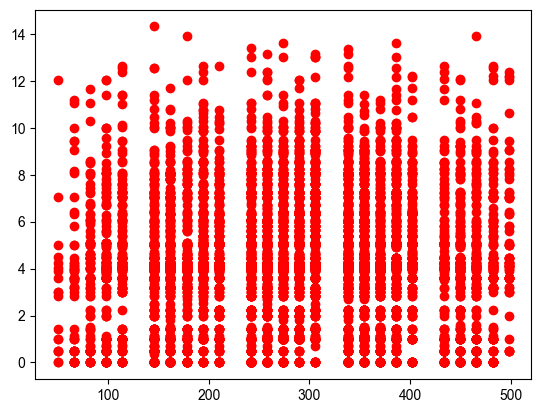

In [529]:
plt.scatter(subfield_results_df['depth'], subfield_results_df['on_off_center_distance'], c='r', label='ON Subfield')

Text(0.5, 1.0, 'Distribution of distance between ON and OFF Subfield Centers')

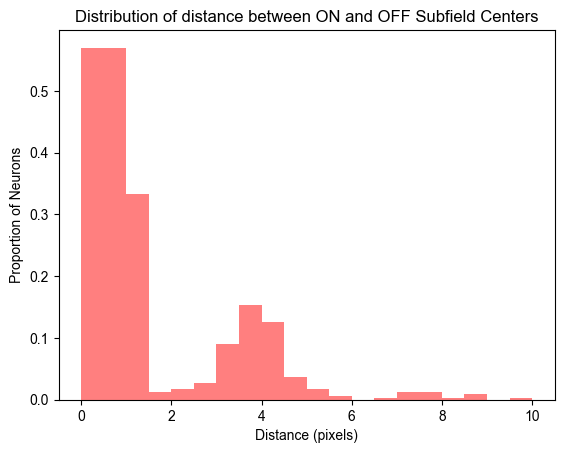

In [655]:
plt.hist(subfield_results_df['on_off_center_distance'], bins=20, color='r', alpha=0.5, label='ON Subfield', density=True)
plt.xlabel('Distance (pixels)')
plt.ylabel('Proportion of Neurons')
plt.title('Distribution of distance between ON and OFF Subfield Centers')

In [645]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
mouse_id_mapping = {
    427836: "slc5",
    438833: "slc4",
    416296: "teto1",
    409828: "slc2",
}
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
    [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

In [646]:
subfield_results_df_temp = subfield_results_df[['mouse_id', 'depth', 'on_off_center_distance']]
subfield_results_df_temp = subfield_results_df_temp.dropna()
subfield_results_df_temp

,mouse_id,depth,on_off_center_distance
34,409828,66,0.500000
48,409828,66,0.000000
94,409828,82,7.433034
98,409828,82,0.000000
100,409828,82,5.000000
...,...,...,...
94109,438833,466,0.000000
94117,438833,466,4.242641
94172,438833,482,0.500000
94303,438833,482,4.242641


In [647]:
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = 4
sample_size = 50
bootstrapped_data = np.zeros((n_bootstrap, n_mice, n_z_groups))

for z, z_group in enumerate(z_groups_high_to_low):
    for m, mouse in enumerate(subfield_results_df_temp['mouse_id'].unique()):
        data = subfield_results_df_temp[(subfield_results_df_temp['mouse_id'] == mouse) & (subfield_results_df_temp['depth'].isin(z_group))]['on_off_center_distance'].values
        if len(data) < 1:
            for b in range(n_bootstrap):
                bootstrapped_data[b, m, z] = np.nan
            continue
        for b in range(n_bootstrap):
            bootstrapped_data[b, m, z] = np.random.choice(data, size=sample_size, replace=True).mean()

Text(0.5, 1.0, 'ON-OFF Center Distance by Depth')

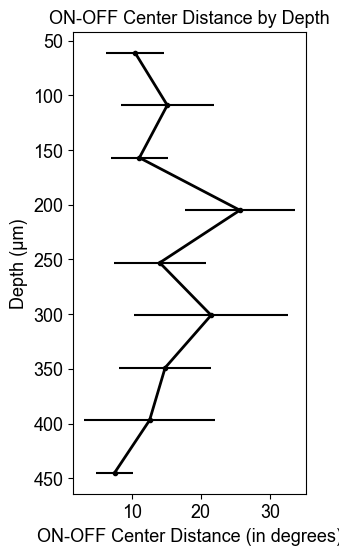

In [659]:
plt.figure(figsize=(3, 6))
jitter_amount = 5
n_z_groups = len(z_groups_high_to_low)
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

means = []
std_errors = []
# mouse_color = mouse_colors[mice[m]]

for z in range(n_z_groups):
    bootstrapped_values = bootstrapped_data[:, :, z] * 9.3
    mean = np.mean(bootstrapped_values)
    std = np.std(bootstrapped_values)
    
    means.append(mean)
    std_errors.append(std)

jitter = fixed_jitters[:, 3-m]
y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter

plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color='black', capsize=0, markersize=3)
plt.plot(means, y_positions, linewidth=2, color='black')

plt.xlabel('ON-OFF Center Distance (in degrees)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Depth (µm)", fontsize=fontsize)
plt.gca().invert_yaxis()
plt.title('ON-OFF Center Distance by Depth', fontsize=fontsize)
    # plt.title(titles[s], fontsize=fontsize, fontname='Arial')

Text(0.5, 1.0, 'ON-OFF Center Distance by Depth')

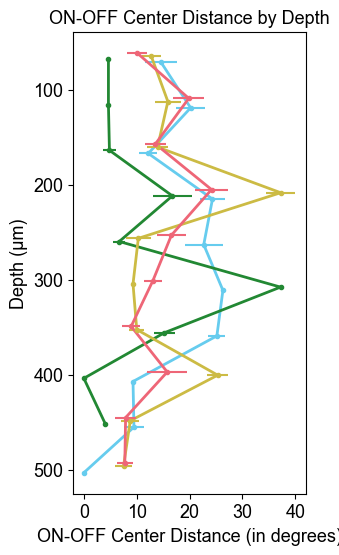

In [648]:
plt.figure(figsize=(3, 6))
jitter_amount = 5
n_z_groups = len(z_groups_high_to_low)
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for m, mouse_id in enumerate(subfield_results_df_temp.mouse_id.unique()):
    means = []
    std_errors = []
    mouse_color = mouse_colors[mice[m]]
    
    for z in range(n_z_groups):
        bootstrapped_values = bootstrapped_data[:, m, z] * 9.3
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    jitter = fixed_jitters[:, 3-m]
    y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter
    
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3)
    plt.plot(means, y_positions, color=mouse_color, linewidth=2)

plt.xlabel('ON-OFF Center Distance (in degrees)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Depth (µm)", fontsize=fontsize)
plt.gca().invert_yaxis()
plt.title('ON-OFF Center Distance by Depth', fontsize=fontsize)
    # plt.title(titles[s], fontsize=fontsize, fontname='Arial')

In [ ]:
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
bootstrapped_data_all_mice = np.zeros((n_bootstrap, n_z_groups))

# Loop over each z_group and compute bootstrapped correlations for each stimulus pair
for z, z_group in enumerate(z_groups_high_to_low):
    plane = subfield_results_df['depth'].isin(z_group)
    data = run_corr_df[plane]["run_corr"].values

    if len(data) > 1:
            for b in range(n_bootstrap):
                sample_indices = np.random.choice(range(len(data)), size=50, replace=True)
                sampled_x = data[sample_indices]
                bootstrapped_data_all_mice[b, z] = np.mean(sampled_x)

In [627]:
# find On/Off subfield if it exists 
mouse_id = 'M427836'
col_vol_str = '53'
plane_name = f"Plane_1"
# plane = 2 
# plane = 3
# plane = 1

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

Loaded session M427836_53, mouse 427836, column 5, volume 3
Loaded dff and event traces for 278 valid ROIs


Cell 9 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.905124837953327
Cell 13 has both ON and OFF subfields
	Distance between ON and OFF subfields 2.9154759474226504
Cell 87 has both ON and OFF subfields
	Distance between ON and OFF subfields 1.0
Cell 88 has both ON and OFF subfields
	Distance between ON and OFF subfields 2.8284271247461903


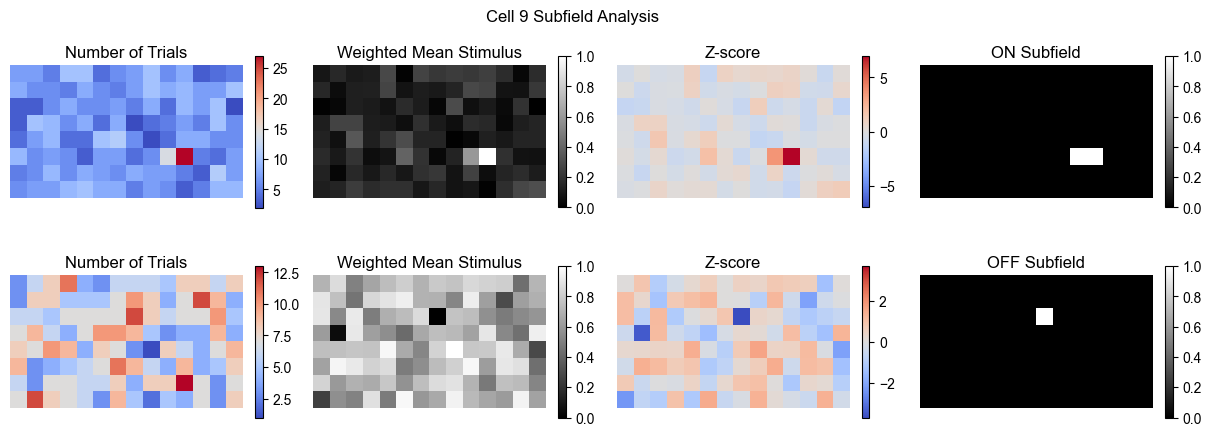

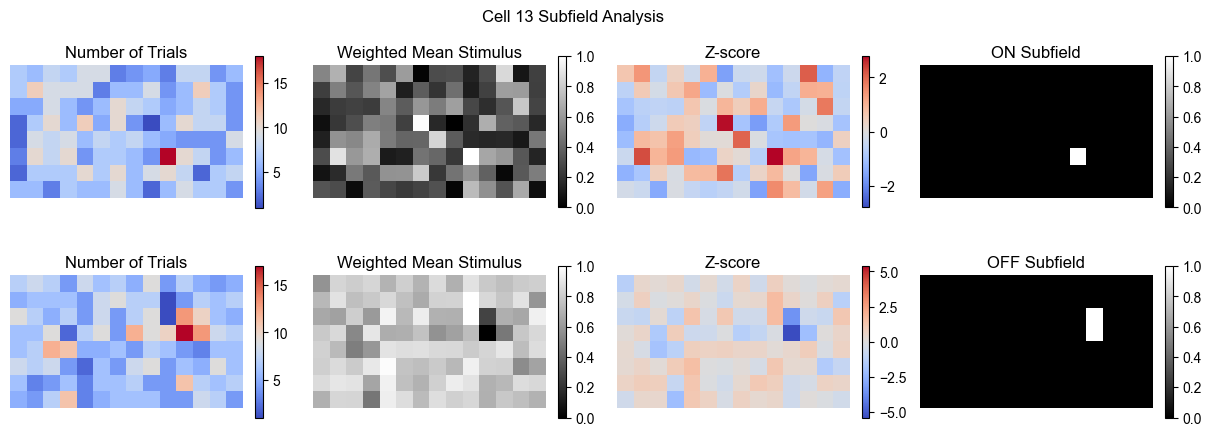

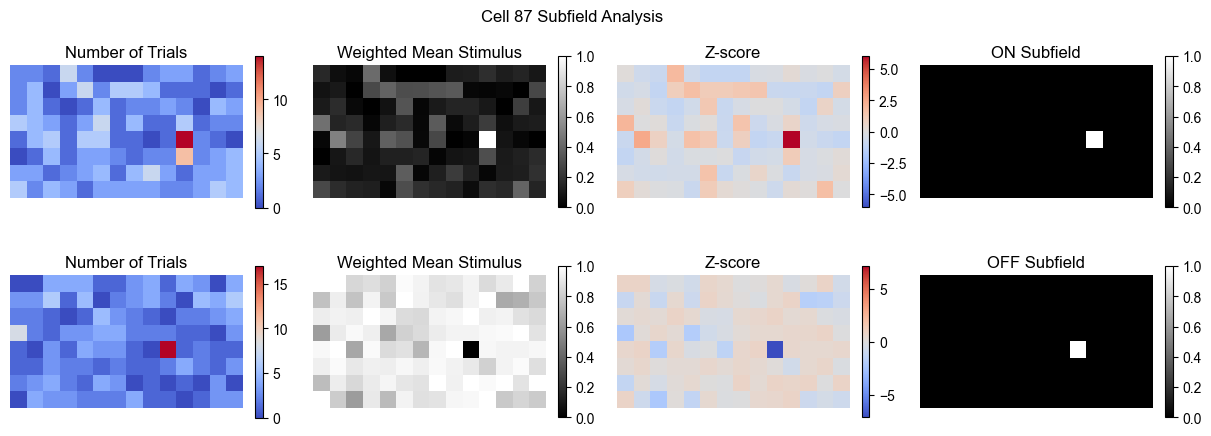

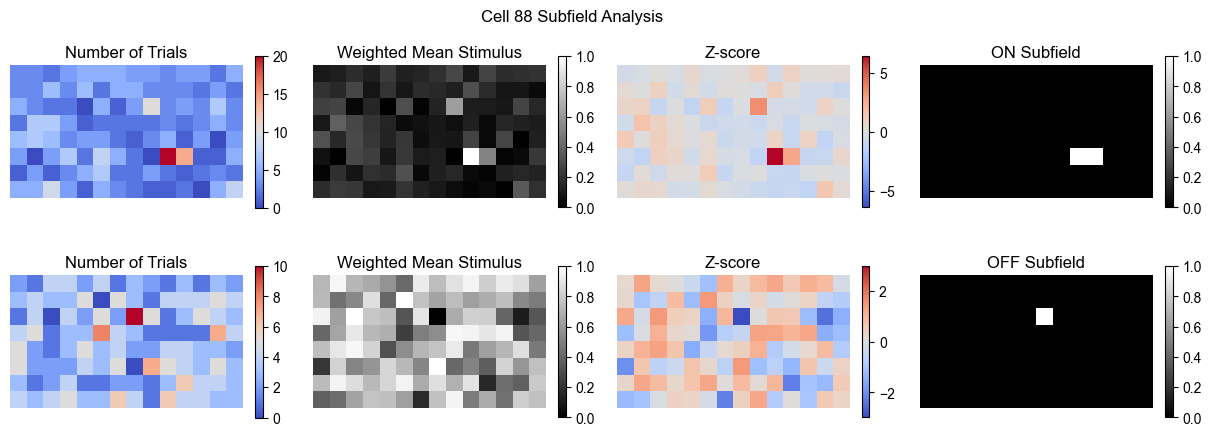

In [637]:
for cell in range(278):
    lsn_values = all_lsn_vals_in_colvol_plane[:, cell]
    pvals = all_pvals_in_colvol_plane[:, cell]
    # is_trial_responsive = pvals < response_thresh_alpha
    # is_trial_responsive = pvals < (response_thresh_alpha / 1705)
    is_trial_responsive = pvals < 0.01
    num_responsive_trials = np.sum(is_trial_responsive)

    design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials
    weighted_avg_for_resp_trials = design_matrix_for_resp_trials.dot(lsn_values[is_trial_responsive]) # weighted (by lsn value) average of responsive stimuli 

    # split into on and off trials
    weighted_avg_for_resp_trials_on = weighted_avg_for_resp_trials[:int(len(weighted_avg_for_resp_trials)/2)]
    weighted_avg_for_resp_trials_off = weighted_avg_for_resp_trials[int(len(weighted_avg_for_resp_trials)/2):]

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on = on_pixels.mean(axis=2)                                                  # mean stimulus for on pixels of responsive trials
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 2.5) & (counts_stim_for_resp_trials_on >= 10)  # threshold for significance
    # norm_count_on = counts_stim_for_resp_trials_on / counts_stim_for_resp_trials_on.sum()
    # on_results = norm_count_on > 0.03

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off = off_pixels.mean(axis=2)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -2.5) & (counts_stim_for_resp_trials_off >= 10)  # threshold for significance
    # norm_count_off = counts_stim_for_resp_trials_off / counts_stim_for_resp_trials_off.sum()
    # off_results = norm_count_off > 0.03

    # check for islands 
    if on_results.sum() > 0:
        on_subfield = True
        on_subfield_pixels = np.where(on_results == True)
        on_center = np.mean(on_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an ON subfield, {on_subfield_pixels}')

    if off_results.sum() > 0:
        off_subfield = True
        off_subfield_pixels = np.where(off_results == True)
        off_center = np.mean(off_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an OFF subfield, {off_subfield_pixels}')

    on_subfield = []

    if np.sum(on_results) > 1:
        # print(f'Cell {cell} has multiple ON subfields')
        biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
        on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
        
        for x, y in zip(on_subfield_pixels[0], on_subfield_pixels[1]):
            distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
            if distance < 1.5:
                on_subfield.append([x, y])
                
            for idx in range(len(on_subfield) - 1):
                # print(idx)
                x, y = on_subfield[idx][0], on_subfield[idx][1]
                # print(f'\tDistance between biggest ON subfield and other ON subfields {distance}')
                # print(x, y)

    elif np.sum(on_results) == 1:
        on_subfield.append([on_subfield_pixels[0][0], on_subfield_pixels[1][0]])

    on_subfield = np.array(on_subfield)
    on_results_new = np.zeros_like(on_results)
    if on_subfield.size > 0:
        on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1

    off_subfield = []

    if np.sum(off_results) > 1:
        biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
        off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
        
        for x, y in zip(off_subfield_pixels[0], off_subfield_pixels[1]):
            distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
            if distance < 1.5:
                off_subfield.append([x, y])
                
            for idx in range(len(off_subfield) - 1):
                # print(idx)
                x, y = off_subfield[idx][0], off_subfield[idx][1]
                # print(f'\tDistance between biggest OFF subfield and other OFF subfields {distance}')
                # print(x, y)

    elif np.sum(off_results) == 1:
        off_subfield.append([off_subfield_pixels[0][0], off_subfield_pixels[1][0]])
        
    off_subfield = np.array(off_subfield)
    off_results_new = np.zeros_like(off_results)
    if off_subfield.size > 0:
        off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

    # plt.tight_layout()
    # fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

    if on_results_new.sum() > 0 and off_results_new.sum() > 0:
        print(f'Cell {cell} has both ON and OFF subfields')
        print(f'\tDistance between ON and OFF subfields {np.sqrt((on_center[0] - off_center[0])**2 + (on_center[1] - off_center[1])**2)}')

        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        # norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
        # sub1 = axs[0, 0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
        # fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        # axs[0, 0].set_title('Mean Stimulus')
        # axs[0, 0].axis('off')

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        axs[1, 3].axis('off')

        fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

# plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)


In [ ]:
# for cell in range(269):
cell = 130
lsn_values = all_lsn_vals_in_colvol_plane[:, cell]
pvals = all_pvals_in_colvol_plane[:, cell]
is_trial_responsive = pvals < response_thresh_alpha
num_responsive_trials = np.sum(is_trial_responsive)

design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials
weighted_avg_for_resp_trials = design_matrix_for_resp_trials.dot(lsn_values[is_trial_responsive]) # weighted (by lsn value) average of responsive stimuli 

# split into on and off trials
weighted_avg_for_resp_trials_on = weighted_avg_for_resp_trials[:int(len(weighted_avg_for_resp_trials)/2)]
weighted_avg_for_resp_trials_off = weighted_avg_for_resp_trials[int(len(weighted_avg_for_resp_trials)/2):]

# calculate ON subfield (if it exists)
on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
mean_stim_for_resp_trials_on = on_pixels.mean(axis=2)                                                  # mean stimulus for on pixels of responsive trials
mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
# on_results = (z_value_results_on > 3.5) & (counts_stim_for_resp_trials_on >= 15)  # threshold for significance
norm_counts = counts_stim_for_resp_trials_on / counts_stim_for_resp_trials_on.sum()
on_results = norm_counts > 0.02

# calculate OFF subfield (if it exists)
off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
mean_stim_for_resp_trials_off = off_pixels.mean(axis=2)
mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
# off_results = (z_value_results_off < -3.5) & (counts_stim_for_resp_trials_off >= 15)  # threshold for significance
norm_counts = counts_stim_for_resp_trials_off / counts_stim_for_resp_trials_off.sum()
off_results = norm_counts > 0.02

# check for islands 
if on_results.sum() > 0:
    on_subfield = True
    on_subfield_pixels = np.where(on_results == True)
    on_center = np.mean(on_subfield_pixels, axis=1)
    # print(f'Cell {cell} has an ON subfield, {on_subfield_pixels}')

if off_results.sum() > 0:
    off_subfield = True
    off_subfield_pixels = np.where(off_results == True)
    off_center = np.mean(off_subfield_pixels, axis=1)
    # print(f'Cell {cell} has an OFF subfield, {off_subfield_pixels}')

on_subfield = []

if np.sum(on_results) > 1:
    # print(f'Cell {cell} has multiple ON subfields')
    biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
    on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
    
    for x, y in zip(on_subfield_pixels[0], on_subfield_pixels[1]):
        distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
        if distance < 1.5:
            on_subfield.append([x, y])
            
        for idx in range(len(on_subfield) - 1):
            # print(idx)
            x, y = on_subfield[idx][0], on_subfield[idx][1]
            # print(f'\tDistance between biggest ON subfield and other ON subfields {distance}')
            # print(x, y)

elif np.sum(on_results) == 1:
    on_subfield.append([on_subfield_pixels[0][0], on_subfield_pixels[1][0]])

on_subfield = np.array(on_subfield)
on_results_new = np.zeros_like(on_results)
if on_subfield.size > 0:
    on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1

off_subfield = []

if np.sum(off_results) > 1:
    biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
    off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
    
    for x, y in zip(off_subfield_pixels[0], off_subfield_pixels[1]):
        distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
        if distance < 1.5:
            off_subfield.append([x, y])
            
        for idx in range(len(off_subfield) - 1):
            # print(idx)
            x, y = off_subfield[idx][0], off_subfield[idx][1]
            # print(f'\tDistance between biggest OFF subfield and other OFF subfields {distance}')
            # print(x, y)

elif np.sum(off_results) == 1:
    off_subfield.append([off_subfield_pixels[0][0], off_subfield_pixels[1][0]])
    
off_subfield = np.array(off_subfield)
off_results_new = np.zeros_like(off_results)
if off_subfield.size > 0:
    off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

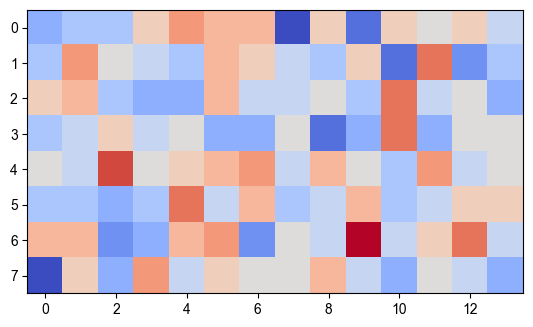

In [590]:
plt.imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')

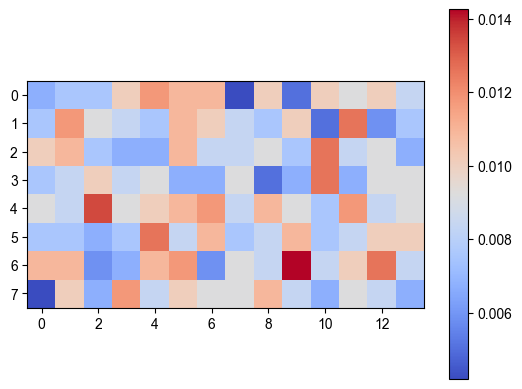

In [592]:
norm_counts = counts_stim_for_resp_trials_on / counts_stim_for_resp_trials_on.sum()
plt.imshow(norm_counts, cmap='coolwarm')
plt.colorbar()

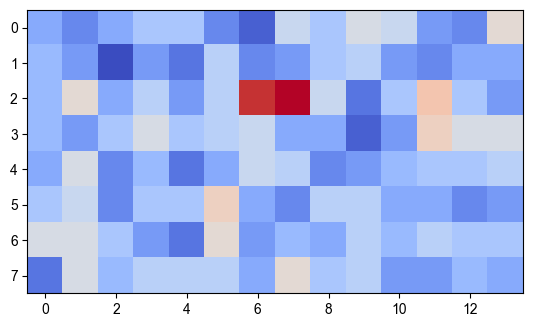

In [593]:
plt.imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')

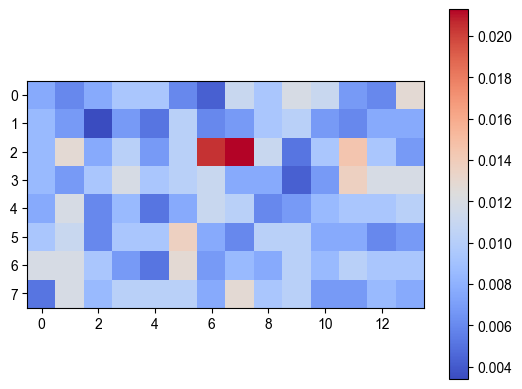

In [595]:
norm_counts_off = counts_stim_for_resp_trials_off / counts_stim_for_resp_trials_off.sum()
plt.imshow(norm_counts_off, cmap='coolwarm')
plt.colorbar()

In [601]:
norm_counts_off[norm_counts_off > 0.018]

array([0.02044293, 0.02129472])

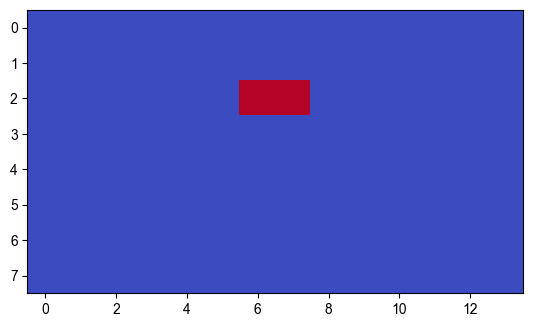

In [603]:
plt.imshow(norm_counts_off > 0.02, cmap='coolwarm')

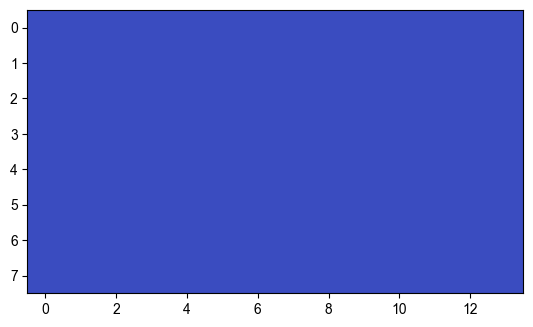

In [600]:
plt.imshow(norm_counts > 0.015, cmap='coolwarm')

In [ ]:

    if on_results_new.sum() > 0 and off_results_new.sum() > 0:
        print(f'Cell {cell} has both ON and OFF subfields')
        print(f'\tDistance between ON and OFF subfields {np.sqrt((on_center[0] - off_center[0])**2 + (on_center[1] - off_center[1])**2)}')

        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        # norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
        # sub1 = axs[0, 0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
        # fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        # axs[0, 0].set_title('Mean Stimulus')
        # axs[0, 0].axis('off')

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        axs[1, 3].axis('off')

        fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

# plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)



In [573]:
# find On/Off subfield if it exists 
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2 

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

# try:
#     session = client.load_ophys_session(session_id)
#     print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')
# except ValueError:
#     print(f"Error loading session {session_id}")

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

# if all_lsn_vals_in_colvol_plane.ndim == 1:
#     all_lsn_vals_in_colvol_plane = all_lsn_vals_in_colvol_plane.reshape(1705, 1)
#     all_pvals_in_colvol_plane = all_pvals_in_colvol_plane.reshape(1705, 1)


Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


Cell 27 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.0
Cell 39 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.1622776601683795
Cell 80 has both ON and OFF subfields
	Distance between ON and OFF subfields 6.708203932499369
Cell 111 has both ON and OFF subfields
	Distance between ON and OFF subfields 7.211102550927978
Cell 140 has both ON and OFF subfields
	Distance between ON and OFF subfields 13.038404810405298
Cell 153 has both ON and OFF subfields
	Distance between ON and OFF subfields 2.8284271247461903
Cell 178 has both ON and OFF subfields
	Distance between ON and OFF subfields 10.770329614269007
Cell 286 has both ON and OFF subfields
	Distance between ON and OFF subfields 9.219544457292887
Cell 304 has both ON and OFF subfields
	Distance between ON and OFF subfields 12.041594578792296
Cell 355 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.0
Cell 405 has both ON and OFF subfields
	Distance between ON and OF

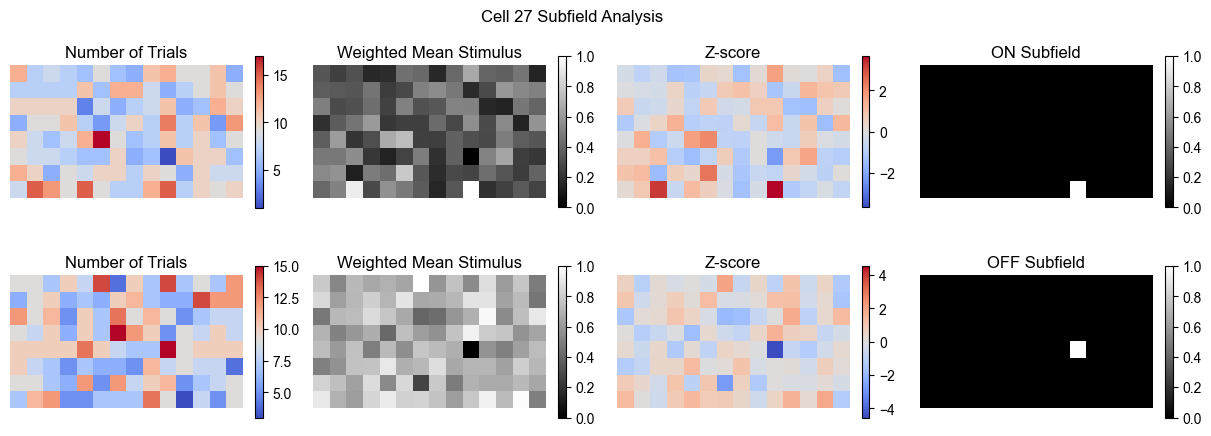

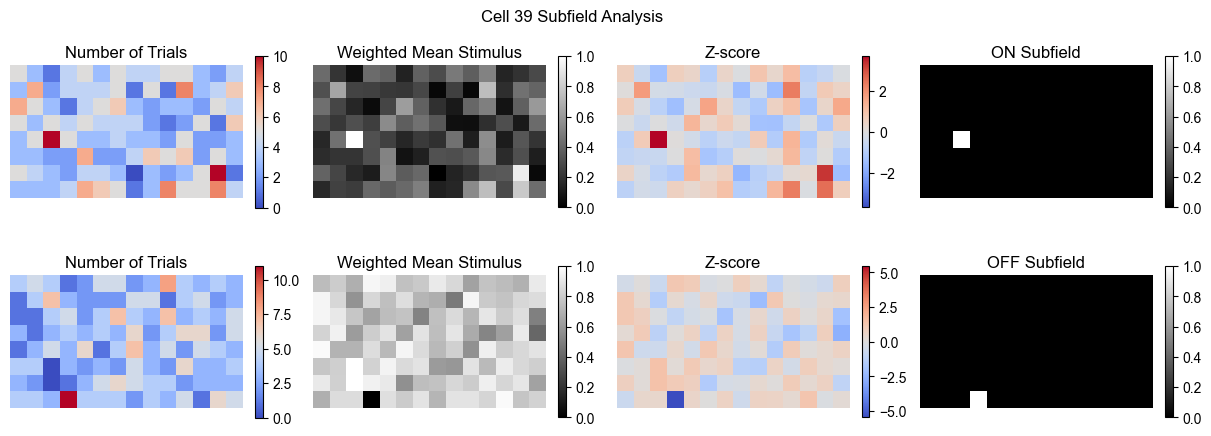

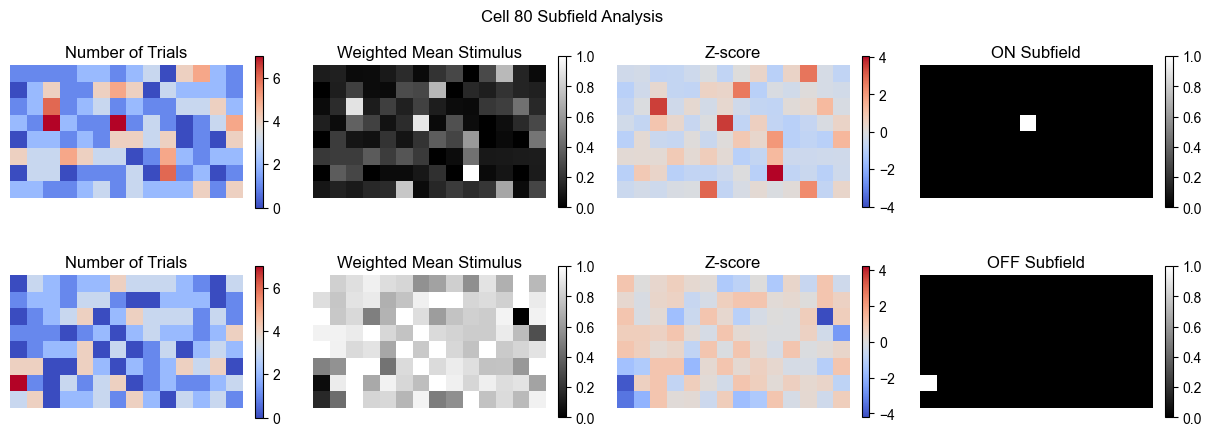

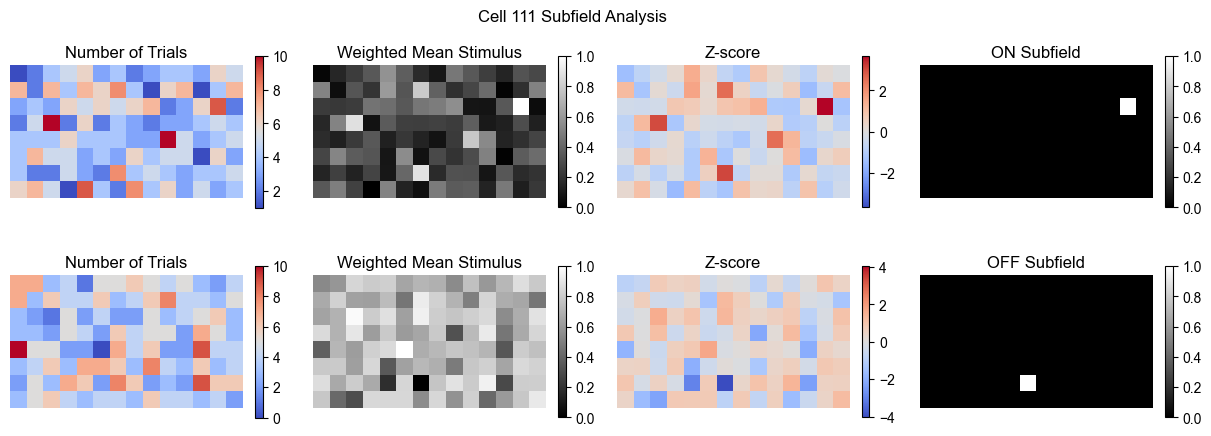

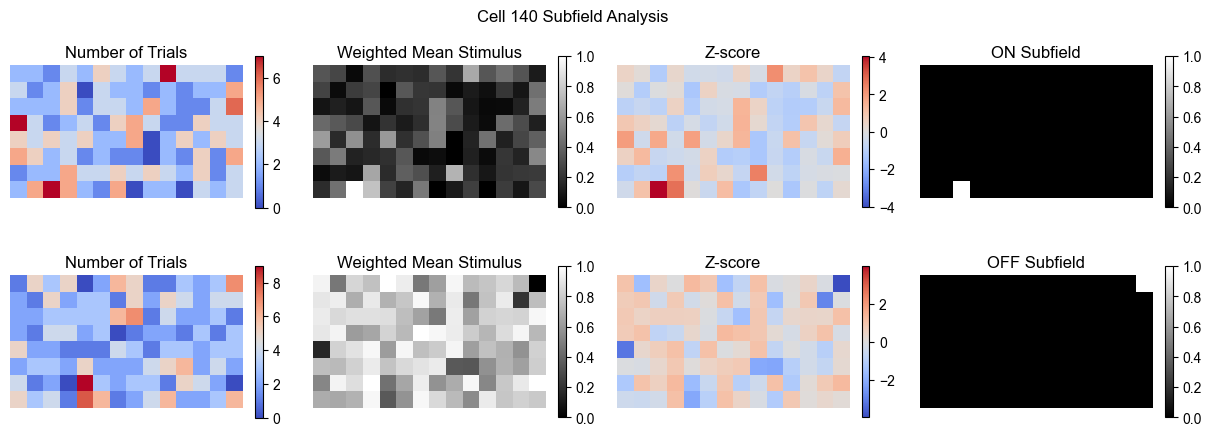

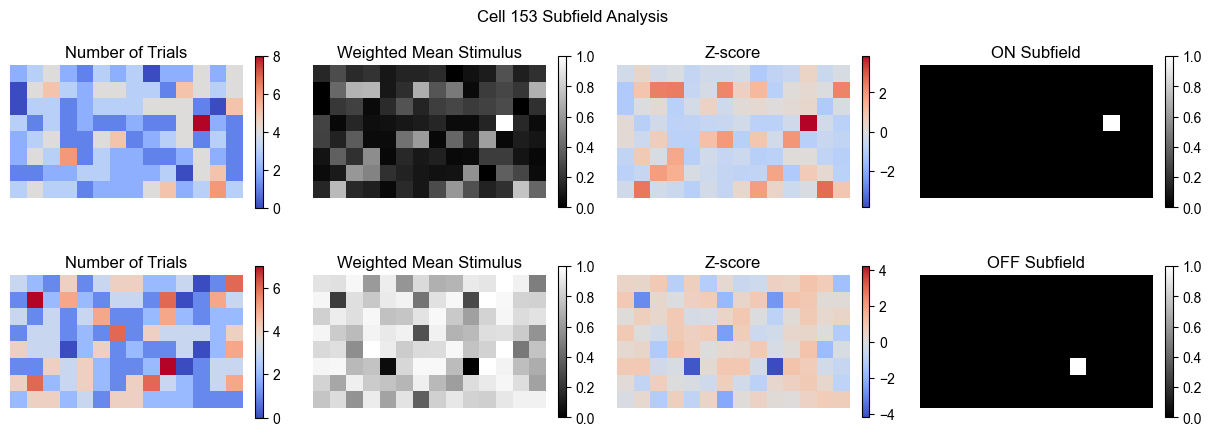

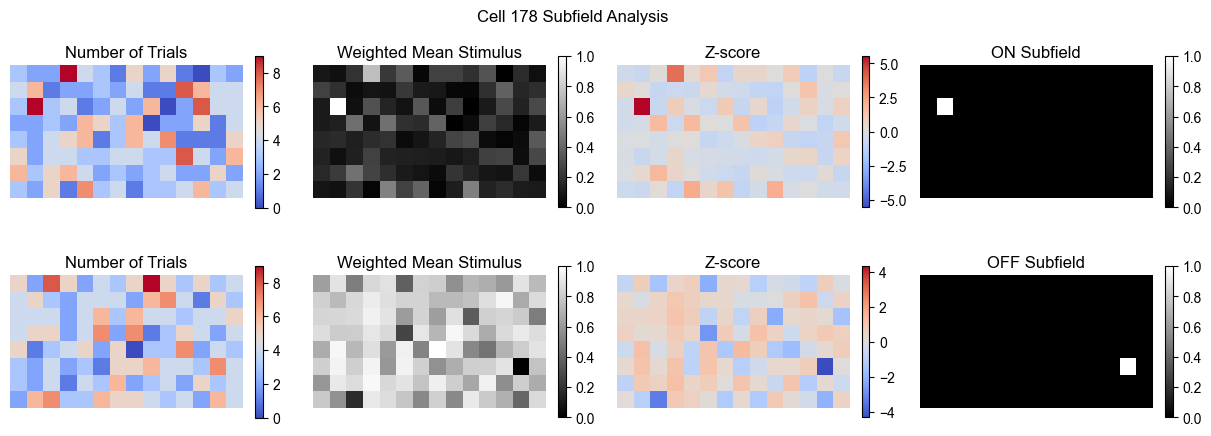

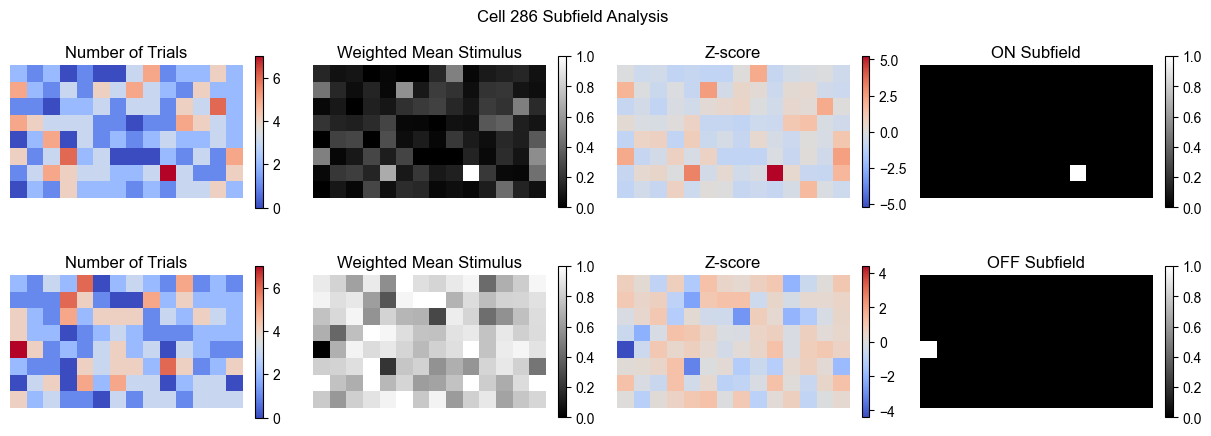

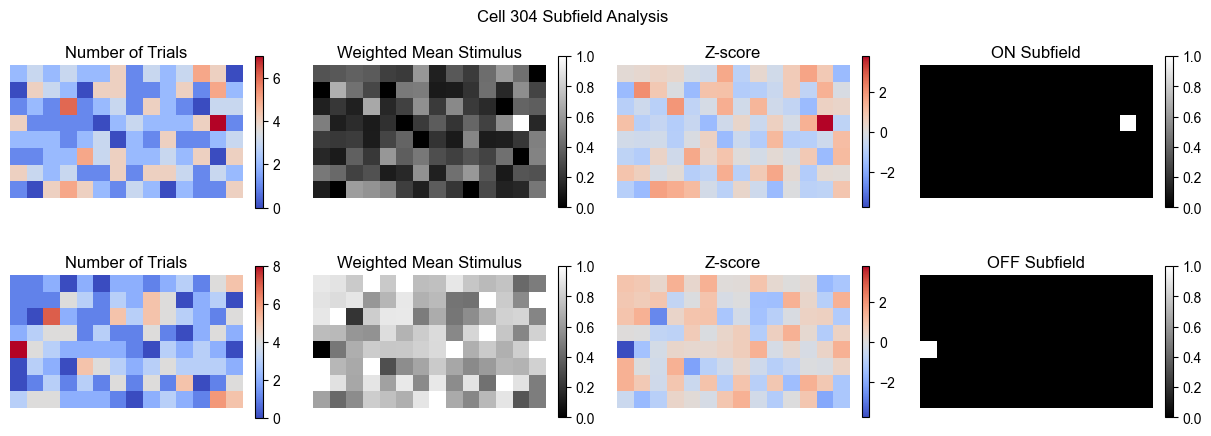

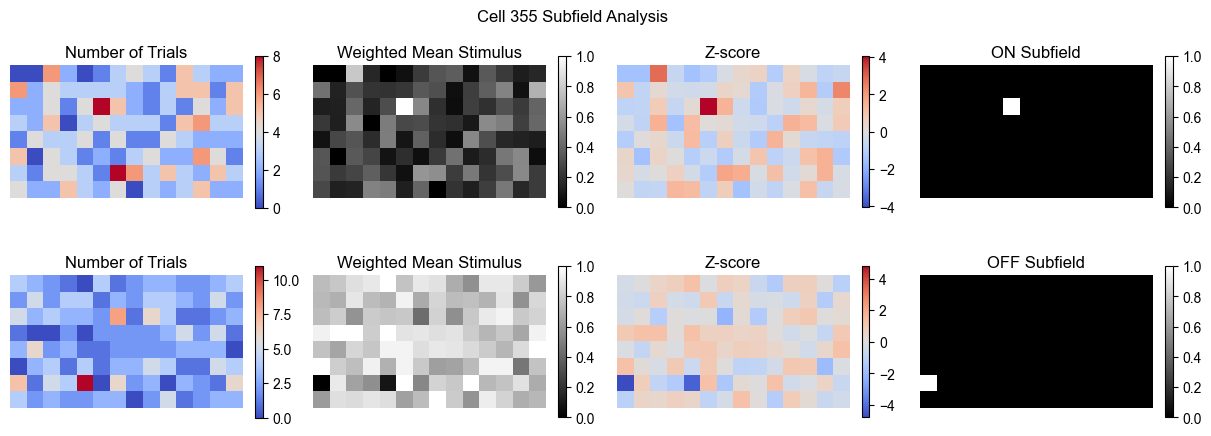

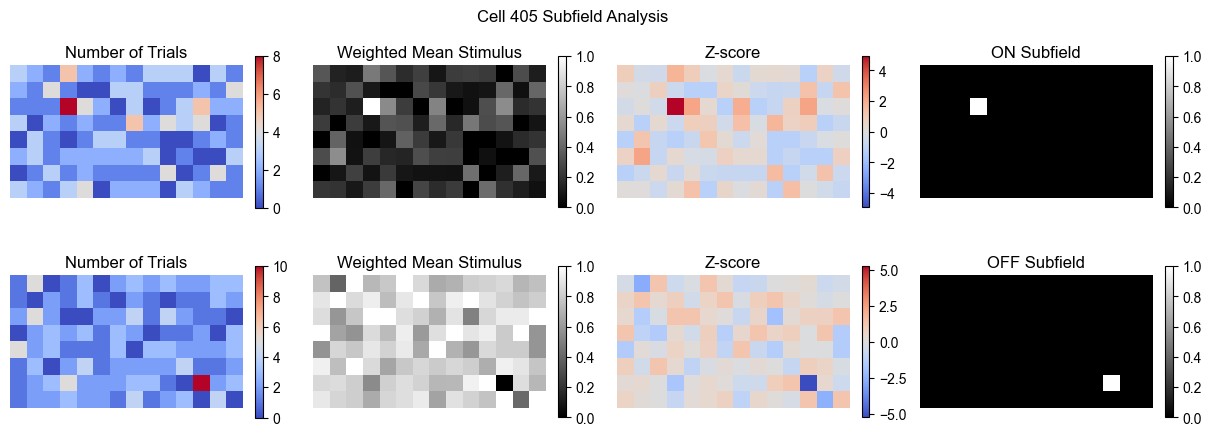

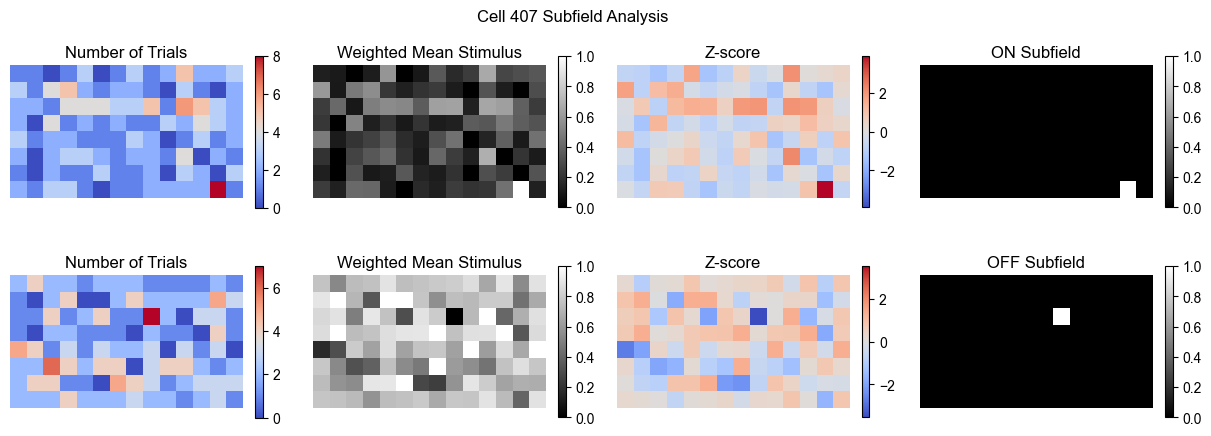

In [ ]:
# find On/Off subfield if it exists 
for cell in range(542):
    lsn_values = all_lsn_vals_in_colvol_plane[:, cell]
    pvals = all_pvals_in_colvol_plane[:, cell]
    is_trial_responsive = pvals < response_thresh_alpha
    num_responsive_trials = np.sum(is_trial_responsive)

    shuffle = True
    if shuffle:
        design_matrix_for_resp_trials = np.roll(design_matrix, 5)[:, is_trial_responsive] # design matrix for responsive trials
    weighted_avg_for_resp_trials = design_matrix_for_resp_trials.dot(lsn_values[is_trial_responsive]) # weighted (by lsn value) average of responsive stimuli 

    # split into on and off trials
    weighted_avg_for_resp_trials_on = weighted_avg_for_resp_trials[:int(len(weighted_avg_for_resp_trials)/2)]
    weighted_avg_for_resp_trials_off = weighted_avg_for_resp_trials[int(len(weighted_avg_for_resp_trials)/2):]

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on = on_pixels.mean(axis=2)                                                  # mean stimulus for on pixels of responsive trials
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 3.5) & (counts_stim_for_resp_trials_on >= 7)  # threshold for significance

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off = off_pixels.mean(axis=2)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -3.5) & (counts_stim_for_resp_trials_off >= 7)  # threshold for significance

    # check for islands 
    if on_results.sum() > 0:
        on_subfield = True
        on_subfield_pixels = np.where(on_results == True)
        on_center = np.mean(on_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an ON subfield, {on_subfield_pixels}')

    if off_results.sum() > 0:
        off_subfield = True
        off_subfield_pixels = np.where(off_results == True)
        off_center = np.mean(off_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an OFF subfield, {off_subfield_pixels}')

    on_subfield = []

    if np.sum(on_results) > 1:
        # print(f'Cell {cell} has multiple ON subfields')
        biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
        on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
        
        for x, y in zip(on_subfield_pixels[0], on_subfield_pixels[1]):
            distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
            if distance < 1.5:
                on_subfield.append([x, y])
                
            for idx in range(len(on_subfield) - 1):
                # print(idx)
                x, y = on_subfield[idx][0], on_subfield[idx][1]
                # print(f'\tDistance between biggest ON subfield and other ON subfields {distance}')
                # print(x, y)

    elif np.sum(on_results) == 1:
        on_subfield.append([on_subfield_pixels[0][0], on_subfield_pixels[1][0]])

    on_subfield = np.array(on_subfield)
    on_results_new = np.zeros_like(on_results)
    if on_subfield.size > 0:
        on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1

    off_subfield = []

    if np.sum(off_results) > 1:
        biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
        off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
        
        for x, y in zip(off_subfield_pixels[0], off_subfield_pixels[1]):
            distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
            if distance < 1.5:
                off_subfield.append([x, y])
                
            for idx in range(len(off_subfield) - 1):
                # print(idx)
                x, y = off_subfield[idx][0], off_subfield[idx][1]
                # print(f'\tDistance between biggest OFF subfield and other OFF subfields {distance}')
                # print(x, y)

    elif np.sum(off_results) == 1:
        off_subfield.append([off_subfield_pixels[0][0], off_subfield_pixels[1][0]])
        
    off_subfield = np.array(off_subfield)
    off_results_new = np.zeros_like(off_results)
    if off_subfield.size > 0:
        off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

    # plt.tight_layout()
    # fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

    if on_results_new.sum() > 0 and off_results_new.sum() > 0:
        print(f'Cell {cell} has both ON and OFF subfields')
        print(f'\tDistance between ON and OFF subfields {np.sqrt((on_center[0] - off_center[0])**2 + (on_center[1] - off_center[1])**2)}')

        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        # norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
        # sub1 = axs[0, 0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
        # fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        # axs[0, 0].set_title('Mean Stimulus')
        # axs[0, 0].axis('off')

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        axs[1, 3].axis('off')

        fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

# plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)